Load Libraries

In [1]:
from __future__ import print_function
import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from warpctc_pytorch import CTCLoss
import os
import utils
import dataset

import models.crnn as crnn

import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('latin-1')
from model_error import cer, wer


#My workaround was that at the top of the script, I import sys, and store sys.stdout in a separate variable, e.g. stdout.
sys.stdout = stdout
print(sys.getdefaultencoding())

latin-1


In [2]:
trainroot = "/home/ubuntu/russell/nephi/data/lmdb/train"
valroot = "/home/ubuntu/russell/nephi/data/lmdb/val"
batchSize = 64
test_batch_size = batchSize
nh = 256                  # size of the LSTM hidden state
imgW = 100
imgH = 32
ngpu = 1
beta1 = 0.5
lr = 0.0001
workers = 10
keep_ratio = True
adam = True
adadelta = False
n_test_disp = 100

alph_file_dylan = "/home/ubuntu/dylan/nephi/alphabet.txt"
alph_file_russell = "/home/ubuntu/russell/nephi/alphabet.txt"
alphabet = '0123456789abcdefghijklmnopqrstuvwxyzB- EÂ¬Ã¼.RSÅ«J/DHA:K¤¿ZLGFNTPCOVWIM<8d>Ä<81><9f>,<93>È³¶'
#0123456789abcdefghijklmnopqrstuvwxyzW VCGū¬.HM,ILAZ:BTÿSER<BC>JFāP<9F>NDKOȳ<B6>
#<A4><8D>()—̈-<84><93>Q<96>/Y<BE>U<>+  # This is what I got from Dylan's file

untrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1_100.pth"
#less trained 29
lesstrained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_1000_100.pth"
trained_crnn_russell = "/home/ubuntu/russell/nephi/expr/netCRNN_3870_100.pth"
trained_crnn_dylan = "/home/ubuntu/dylan/nephi/expr/netCRNN_3210_100.pth"

In [3]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9443


In [4]:
#cudnn.benchmark = True
#cuda = True

#if torch.cuda.is_available() and not cuda:
#    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

#train_dataset = dataset.lmdbDataset(root=trainroot)
#sampler = dataset.randomSequentialSampler(train_dataset, batchSize)
#train_loader = torch.utils.data.DataLoader(
#    train_dataset, batch_size=batchSize, sampler=sampler,
#    num_workers=int(workers),
#    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

#training_eval_set = dataset.lmdbDataset(
#    root=trainroot, transform=dataset.resizeNormalize((imgW, imgH))) 
#test_dataset = dataset.lmdbDataset(
#    root=valroot, transform=dataset.resizeNormalize((imgW, imgH)))   # I have changed this line from the original code

In [5]:
cudnn.benchmark = True
cuda= True

train_dataset = dataset.lmdbDataset(root=trainroot)
assert train_dataset
sampler = dataset.randomSequentialSampler(train_dataset, batchSize)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchSize, sampler=sampler,
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

test_dataset = dataset.lmdbDataset(root=valroot)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, sampler=dataset.randomSequentialSampler(test_dataset, test_batch_size),
    num_workers=int(workers),
    collate_fn=dataset.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=keep_ratio))

In [6]:
# Load in the two alphabets
alphabet_russell = ''
alphabet_dylan = ''

with open(alph_file_russell, 'r') as myfile:
    alphabet_russell = myfile.read()
with open(alph_file_dylan, 'r') as myfile:
    alphabet_dylan = myfile.read()

# Test the dylan ALphabet and model first
alphabet = alphabet_dylan

nclass = len(alphabet) + 1
nc = 1

converter = utils.strLabelConverter(alphabet)
criterion = CTCLoss()

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
crnn = crnn.CRNN(imgH, nc, nclass, nh)
crnn.apply(weights_init)

CRNN (
  (cnn): Sequential (
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU (inplace)
    (pooling0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU (inplace)
    (pooling1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU (inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU (inplace)
    (pooling2): MaxPool2d (size=(2, 2), stride=(2, 1), dilation=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu4): ReLU (inplace)
    (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)          # RA: I don't understand why the text has this size
length = torch.IntTensor(batchSize)

if cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

In [9]:
print(crnn)

DataParallel (
  (module): CRNN (
    (cnn): Sequential (
      (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu0): ReLU (inplace)
      (pooling0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU (inplace)
      (pooling1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu2): ReLU (inplace)
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU (inplace)
      (pooling2): MaxPool2d (size=(2, 2), stride=(2, 1), dilation=(1, 1))
      (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu4): ReLU (inplace)
      (co

In [10]:
image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager
loss_avg = utils.averager()

# setup optimizer
if adam:
    optimizer = optim.Adam(crnn.parameters(), lr=lr,
                           betas=(beta1, 0.999))
elif adadelta:
    optimizer = optim.Adadelta(crnn.parameters(), lr=lr)
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=lr)

In [11]:
def val(net, dataset, criterion, max_iter=2000):
print('Start val')

for p in crnn.parameters():
    p.requires_grad = False

net.eval()

# RA: Testing out resizing 
#data_loader = torch.utils.data.DataLoader(
#    dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))
#val_iter = iter(data_loader)
val_iter = iter(dataset)

i = 0
n_correct = 0
loss_avg = utils.averager()

image_count = 0
# Character and word error rate lists
char_error = []
w_error = []

max_iter = min(max_iter, len(dataset))
for i in range(max_iter):
    data = val_iter.next()
    i += 1
    cpu_images, cpu_texts = data
    batch_size = cpu_images.size(0)
    image_count = image_count + batch_size
    utils.loadData(image, cpu_images)
    t, l = converter.encode(cpu_texts)
    utils.loadData(text, t)
    utils.loadData(length, l)

    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    cost = criterion(preds, text, preds_size, length) / batch_size
    loss_avg.add(cost)


    # RA: While I am not sure yet, it looks like a greedy decoder and not beam search is being used here
    # Also, a simple character by character accuracy is being used, not an edit distance.
    # Case is ignored in the accuracy, which is not ideal for an actual working system

    _, preds = preds.max(2)
    preds = preds.squeeze(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
    for pred, target in zip(sim_preds, cpu_texts):
        if pred == target.lower():
            n_correct += 1

        # Case-insensitive character and word error rates
        char_error.append(cer(pred, target.lower()))
        w_error.append(wer(pred, target.lower()))

raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:n_test_disp]
for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
    print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

print("Total number of images in validation set: %8d" % image_count)

accuracy = n_correct / float(max_iter * batchSize)
print('Test loss: %f, accuracy: %f' % (loss_avg.val(), accuracy))

char_arr = np.array(char_error)
w_arr = np.array(w_error)
print("Character error rate mean: %4.4f; Character error rate sd: %4.4f" % (np.mean(char_arr), np.std(char_arr, ddof=1)))
print("Word error rate mean: %4.4f; Word error rate sd: %4.4f" % (np.mean(w_arr), np.std(w_arr, ddof=1)))

return (char_error, w_error)


# Now test this on the training set, with and without loading one of my currently good pre-trained models

# Today (24 February 2018), while I was still training another model with aspect ratio preserved, I kept running out of memory in this code. The problem was the batch size. Reducing to 32 allows me to test.

In [12]:
val(crnn, train_loader, criterion, 20)    # Reduce iterations to reduce memory, maybe
# CUDA doesn't have enough memory for this. I may just have to wait, or I could exit out of my other kernal.

Start val
mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm => m                   , gt: Sarchstain, aūf welichen ain Mons¬
mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm => m                   , gt: strannzen, vnd aūf dem Anndern Sarch¬
mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm => m                   , gt: March stain. des Pinter gebreichigs
mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm => m                   , gt: Hanndtwerckhs Zaichen. vnd ain Epi¬
mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm => m                   , gt: tāūiūm. so im: 1581. Jar Reno¬
mmmmmmmmmmmmmmmmmmmmmmmm

([30.0,
  28.0,
  30.0,
  30.0,
  13.0,
  8.0,
  3.0,
  26.0,
  23.0,
  25.0,
  17.0,
  17.0,
  17.0,
  21.0,
  19.0,
  24.0,
  6.0,
  27.0,
  23.0,
  23.0,
  26.0,
  23.0,
  23.0,
  17.0,
  22.0,
  26.0,
  25.0,
  14.0,
  13.0,
  3.0,
  25.0,
  19.0,
  32.0,
  31.0,
  34.0,
  31.0,
  30.0,
  13.0,
  5.0,
  2.0,
  26.0,
  29.0,
  30.0,
  13.0,
  23.0,
  24.0,
  32.0,
  27.0,
  29.0,
  29.0,
  14.0,
  12.0,
  8.0,
  11.0,
  16.0,
  27.0,
  29.0,
  29.0,
  26.0,
  25.0,
  28.0,
  23.0,
  23.0,
  32.0,
  25.0,
  27.0,
  32.0,
  26.0,
  8.0,
  7.0,
  28.0,
  26.0,
  27.0,
  30.0,
  31.0,
  33.0,
  22.0,
  11.0,
  11.0,
  2.0,
  27.0,
  26.0,
  26.0,
  22.0,
  24.0,
  27.0,
  28.0,
  7.0,
  23.0,
  21.0,
  23.0,
  17.0,
  21.0,
  16.0,
  5.0,
  25.0,
  22.0,
  20.0,
  25.0,
  5.0,
  24.0,
  25.0,
  23.0,
  25.0,
  13.0,
  7.0,
  8.0,
  23.0,
  26.0,
  26.0,
  28.0,
  30.0,
  28.0,
  13.0,
  2.0,
  20.0,
  23.0,
  29.0,
  26.0,
  26.0,
  27.0,
  27.0,
  27.0,
  26.0,
  28.0,
  24.0,
  24.0,


In [12]:
# 800 is an expected overfit model
expect_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_800_131.pth"
# 780 is expected to not overfit as much
expect_great = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_780_131.pth"

very_overfit = "/home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_850_131.pth"
# we'll see how we do

pre_trained_model = very_overfit
print('loading pretrained model from %s' % pre_trained_model)
crnn.load_state_dict(torch.load(pre_trained_model))

loading pretrained model from /home/ubuntu/russell/nephi/expr_test_keepaspect_3000/netCRNN_850_131.pth


In [13]:
# I loaded the overfit model here, turns out as expected on training. Maybe I can do test batch same way.
val(crnn, train_loader, criterion, 20)    # Reduce iterations to reduce memory, maybe
# CUDA doesn't have enough memory for this. I may just have to wait, or I could exit out of my other kernal.

Start val
i------------neee----nnn  pp-------iinnn--tttteee---rrr------nn    vv----iii--l-----  ppp----ee--sss--ssss--eee----rr--  aa------nnnnsss-tt---iiee------nndd---. => inen pintern vil pesser anstiend., gt: Inen Pintern vil Pesser Anstiend.
333--------------------------------------222-------------------------------------------------------------------------------------------------------------------- => 32                  , gt: 32                  
s--------ttt--aa---iiinnn--  ee------iiiinnggg--ee---sssseee----nnn---nn----cck---hh----ttt---   ww-----e---rrr----ddd-eee--nnn    sss-oo--ll---llleee---nnnn-.. => stain eingesennckht werden sollen., gt: Stain eingesennckht werden sollen.
d-------aaa---------mmmii---ttt---  dddd---ee---rr----    vvv----ee--lll----ll---iigg----eee----  zzz-----��ū�ee----  rr-------�ū-----nn-sssss---sss----ttt--- => damit der vellige zūe rūnsst, gt: damit der vellige Zūe rūnsst
-----------------------------------pppp------------------eeee----------------s

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.037037037037037035,
  0.0,
  0.0,
  0.0,
  0.034482758620689655,
  0.0,
  0.09090909090909091,
  0.0,
  0.0,
  0.0,
  0.07142857142857142,
  0.0,
  0.0,
  0.0,
  0.06666666666666667,
  0.0,
  0.05555555555555555,
  0.0,
  0.07142857142857142,
  0.0,
  0.0,
  0.0,
  0.06896551724137931,
  0.0,
  0.0,
  0.06896551724137931,
  0.0,
  0.0,
  0.0,
  0.12903225806451613,
  0.0,
  0.15625,
  0.034482758620689655,
  0.12,
  0.0,
  0.13333333333333333,
  0.03333333333333333,
  0.038461538461538464,
  0.0,
  0.0,
  0.09375,
  0.03333333333333333,
  0.0,
  0.0625,
  0.0,
  0.1,
  0.0,
  0.06666666666666667,
  0.043478260869565216,
  0.15384615384615385,
  0.0,
  0.13793103448275862,
  0.03225806451612903,
  0.0,
  0.07692307692307693,
  0.0,
  0.06896551724137931,
  0.02857142857142857,
  0.06666666666666667,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.

In [15]:
# I loaded the less overfit model here, turns out as expected on training. Maybe I can do test batch same way.
val(crnn, train_loader, criterion, 20)    # Reduce iterations to reduce memory, maybe
# results as excpected

Start val
ww------iir----d--igg---iissstt-- zz-�ū�-   ddeee--nn  k-----rrr--aa---nn---nn--cckkkhhhhenn => wirdigist zū den krannckhen, gt: wirdigist Zū den Krannckhen
gg-eeee--ttrr---aa--gg--ee----nn  w------iirr----dd-ttt--   .((..www---ee-iii-ll-nn dd---iin  => getragen wirdt .(.weiln din , gt: getragen wirdt .(.weiln die 
a---ll--ttee---nnn e---tt---ww---aa-ss    a---bb-ssschhh-�ä---zz--i�---..))) -----mmaa--izz- => alten etwas abschäzi�.) maiz, gt: Alten etwas Abschäzig.). mach
zee-ll-aa-sss-ss--ee--nnn..-     ----------------------s----oo-ll--lee--nn aa--l--llaa-ii--nn => zelassen. sollen allain, gt: Zelassen. Sollen allain
d-----i�e--  fff--ö------ddd-leee--nnn  gg-ee------maaa---cchhht-   ww---e--rr--ddd-ee---nn. => di�e födlen gemacht werden., gt: die Fändlen gemacht werden.
dd--aa--ss-   aa---nnn---nddd-ee--rr---  ddd-ee---r----zzzzee--iiittteeee---nn    ff--��ü�-- => das annder derzeiten fü, gt: das Annder derzeiten für
aa--iiinn   v̈�beee-rr--h--ll��ū�ß-----  gg-ee--hhhaa-ll

([0.06451612903225806,
  0.06666666666666667,
  0.03225806451612903,
  0.0625,
  0.0,
  0.05555555555555555,
  0.06666666666666667,
  0.5,
  0.0,
  0.0,
  0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.0,
  0.029411764705882353,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09090909090909091,
  0.0,
  0.06451612903225806,
  0.0,
  0.0,
  0.07692307692307693,
  0.0,
  0.03125,
  0.0,
  0.0625,
  0.0,
  0.0,
  0.09090909090909091,
  0.0,
  0.0,
  0.025,
  0.0,
  0.1111111111111111,
  0.05,
  0.034482758620689655,
  0.13333333333333333,
  0.03333333333333333,
  0.034482758620689655,
  0.0625,
  0.029411764705882353,
  0.06451612903225806,
  0.11428571428571428,
  0.0,
  0.038461538461538464,
  0.03125,
  0.0,
  0.03571428571428571,
  0.75,
  0.08108108108108109,
  0.0,
  0.07142857142857142,
  0.0,
  0.0,
  0.0,
  0.0,
  0.06896551724137931,
  0.034482758620689655,
  0.0,
  0.0,
  0.0,
  0.02631578947368421,
  0.0,
  0.0,
  0.0,
  0.0

In [13]:
# I loaded the less overfit model here, used test batch size of 32
val(crnn, test_loader, criterion, 1000)    # Reduce iterations 

Start val
v-------bb--ee---rrr----   ddd------iiee----   ss-----tt--aaa-----hh----t---  bb-------a-------zzz--ee------nnn => vber die staht bazen, gt: aber die Statt Bozen
aa-----�ū��hh----ggg----ll--aaa-sss--sss----eee-----nn   a----rr----��ū�rr-----ddd-------.   ss-----iie--ch-- => aūhglassen arūrd. siech, gt: Aūsglassen wūrde. sich 
d--------ee---sss---ss�-------ee-------nnnn    z----�ūe--bbb----ee-----ee----ll----aaa---------zz--ee-----nnn. => dess�en zūebeelazen., gt: dessen Zūbeclagen. 
k-------------------------------ee------------i------nn------e--------------maa---------oo---------cccl-------- => keinemaocl          , gt: General             
t-------------s--------------------------x------a-------ä�--------t----------ū-----------------nnngg--------. => tsxaätūng.        , gt: Raitūng            
z------------re---ö--ee---nn    hh-----�a----ū�--bb---t-----mm-aa----nnn----   kh------o�---lllee---rr---t--- => zreöen h�aūbtman kho�lert, gt: Wegen Haūbtmann Kōlers
l----ee-----   i

([0.13043478260869565,
  0.08,
  0.17647058823529413,
  0.3125,
  0.3,
  0.15,
  0.047619047619047616,
  0.1,
  0.2222222222222222,
  0.14285714285714285,
  0.7272727272727273,
  1.0,
  0.5217391304347826,
  0.3888888888888889,
  0.15384615384615385,
  0.5,
  0.6666666666666666,
  0.8181818181818182,
  0.4,
  0.04,
  0.08695652173913043,
  0.08695652173913043,
  0.25925925925925924,
  0.09523809523809523,
  0.3181818181818182,
  0.11538461538461539,
  0.0,
  0.09523809523809523,
  0.08333333333333333,
  0.16666666666666666,
  0.3333333333333333,
  0.19047619047619047,
  0.5217391304347826,
  0.3888888888888889,
  0.15384615384615385,
  0.5,
  0.6666666666666666,
  0.8181818181818182,
  0.4,
  0.04,
  0.08695652173913043,
  0.08695652173913043,
  0.25925925925925924,
  0.09523809523809523,
  0.3181818181818182,
  0.11538461538461539,
  0.0,
  0.09523809523809523,
  0.08333333333333333,
  0.16666666666666666,
  0.3333333333333333,
  0.19047619047619047,
  0.6,
  0.043478260869565216,
  0

#### Interesting, with a batch size of 2, the test performance was actually worse than a batch size of 32. From this I hypothesize that the procedure for resizing the training images should be likewise used for the test 

In [13]:
# I loaded the less overfit model here, used test batch size of 2
val(crnn, test_loader, criterion, 1000)    # Reduce iterations 

# I'd like to image this now too!



Start val
s                    => s                   , gt: Priuilegium die bewonūng
Total number of images in validation set:     1043
Test loss: 79.031499, accuracy: 0.000299
Character error rate mean: 0.6375; Character error rate sd: 1.0143
Word error rate mean: 1.1024; Word error rate sd: 0.6980


([0.42857142857142855,
  3.0,
  0.5,
  1.0588235294117647,
  0.3684210526315789,
  0.2727272727272727,
  0.4074074074074074,
  1.0,
  1.3333333333333333,
  1.4705882352941178,
  0.3793103448275862,
  0.13636363636363635,
  0.42857142857142855,
  0.45454545454545453,
  0.45,
  0.43478260869565216,
  0.6111111111111112,
  0.07692307692307693,
  0.5909090909090909,
  0.20833333333333334,
  0.4090909090909091,
  0.3,
  0.34782608695652173,
  0.22727272727272727,
  0.4444444444444444,
  1.2307692307692308,
  0.6875,
  0.6875,
  0.6666666666666666,
  0.631578947368421,
  0.47058823529411764,
  0.55,
  0.36,
  0.45454545454545453,
  0.9473684210526315,
  0.35714285714285715,
  0.34782608695652173,
  0.4782608695652174,
  0.4444444444444444,
  0.38095238095238093,
  0.04,
  0.15,
  0.09090909090909091,
  0.42857142857142855,
  1.1,
  1.125,
  0.21428571428571427,
  0.47368421052631576,
  1.0,
  0.8181818181818182,
  0.3157894736842105,
  0.5555555555555556,
  0.4444444444444444,
  0.16,
  0.16

In [13]:
# Now here is with a very overfit model, with total batch size of 64
val(crnn, test_loader, criterion, 1000)    # Reduce iterations 

# Virtually identical results of less overfit model, with batch size of 32.

Start val
d---ee--�ß�-----ggg---ll-ee----iiicchheee---nnn    istt--  gg---ee--------mmme----ll---teee---rr-  pp--i-nn--ckkhhhh-- => deßgleichen ist gemelter pinckh, gt: Deßgleichen ist gemelter Peckh
e---------------------iiiccchh--   --ppp------::    50-0----fff-ff--------   ss---iss-tt---rr----aa---fff---fff-----t-. => eich p: 500ff sistrafft., gt: Aūch P: 10 fl gstrafft
v-------------------------c---------oo----------i-------ccr----------- www----------------------------l------idd------- => vcoicr wlid         , gt: Geörg Wild         
k----------------------tttt-------------rrr-------------------a------------------------------------t------------------- => ktrat               , gt: Straff              
----------------------------nn---------------------------000----------------------   pf-----------------------------... => n0 pf.              , gt: —: 10 fl.         
s----------------iiis----  e-----ffff-----f-----   ---------iiitv---ee---rrrr---- t------- hhh--aaa---ttt---sss--cchh

([0.17391304347826086,
  0.21052631578947367,
  0.09523809523809523,
  0.13043478260869565,
  0.1,
  0.041666666666666664,
  0.21052631578947367,
  0.0,
  0.18181818181818182,
  0.3157894736842105,
  0.21739130434782608,
  0.09523809523809523,
  0.047619047619047616,
  0.375,
  0.09523809523809523,
  0.0,
  0.14285714285714285,
  0.8,
  0.5555555555555556,
  0.4666666666666667,
  0.38461538461538464,
  1.75,
  2.0,
  0.2608695652173913,
  0.21428571428571427,
  0.25,
  0.8571428571428571,
  0.375,
  0.20833333333333334,
  0.42857142857142855,
  0.041666666666666664,
  0.3,
  0.09523809523809523,
  0.15625,
  0.42105263157894735,
  0.25925925925925924,
  0.24,
  0.2692307692307692,
  0.3076923076923077,
  0.08333333333333333,
  0.10714285714285714,
  0.6,
  0.2,
  0.2962962962962963,
  0.8181818181818182,
  0.8333333333333334,
  1.0,
  0.5,
  0.5,
  1.25,
  0.45,
  0.5,
  0.5,
  5.0,
  0.6666666666666666,
  0.7,
  0.5789473684210527,
  0.47619047619047616,
  1.0,
  0.0,
  0.1,
  0.14285

# Now (26 Feb 2018) I will demo code to pad images that are smaller than a given aspect ratio. This will maintain their size and reduce distortion.

From:
- https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

It looks like I managed to fix it pretty easily in the dataset.py code. I am currently training the models now.

In [1]:
# actually, let's just read in one of the jpeg files! so much easie

%matplotlib inline

from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageOps

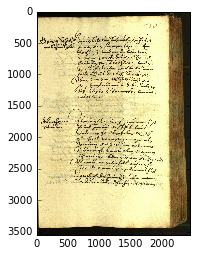

In [2]:
demo_file = "/home/ubuntu/datasets/read_curtis/Training/Images/Seite0061.JPG"
img_pil = Image.open(demo_file, 'r')
imshow(img_pil)

In [29]:
img_pil.size

(2442, 3551)

In [3]:
osize = img_pil.size
nsize = (3000, 3000)

In [4]:
delta_w = nsize[0] - osize[0]
delta_h = nsize[1] - osize[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
new_im = ImageOps.expand(img_pil, padding, "white")



In [7]:
int(round(1.54555))

2

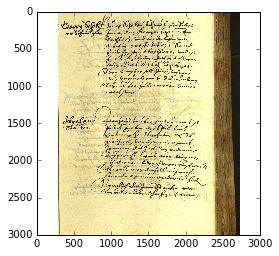

In [5]:
imshow(new_im)

In [ ]:
deltaw=nw-ow
deltah=nh-oh
ltrb_border=(deltaw/2,deltah/2,deltaw-(deltaw/2),deltah-(deltah/2))
img_with_border = ImageOps.expand(img,border=ltrb_border,fill='black')
img_with_border.save('imaged-with-border.png')